# Permeability Prediction of Core Samples

![separator2](https://i.imgur.com/4gX5WFr.png)

This is a little practice project I did to hone my skills in data analysis. I am still on a learning stage so bare with me. I have a background in petroleum engineering so it was great that I was able to find a dataset within my domain. 


The rock.csv file was obtained from Kaggle with no description from the uploader. Thus, I don't have any information about the methodology of measurement and specific units used in the dataset. I was continuously figuring out how to process the data throughout this whole project Again, bare with me. Thank you.

![separator2](https://i.imgur.com/4gX5WFr.png)


### Introduction

In this simple study, we'll try to predict the Permeability of a Core Sample using the informations contained in the rock.csv dataset. The first part is focused on understanding the data and its variables using statistical analysis and visualization techniques. After that, I applied multiple linear regression using gradient descent and other algorithms that I am currently learning to execute in Python. Then, I will evaluate the different models established and decide which is the optimal choice to predict Permeability.

#### Installing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.read_csv('rock.csv').head(20)

,Unnamed: 0,area,peri,shape,perm
0,1,4990,2791.90,0.090330,6.3
1,2,7002,3892.60,0.148622,6.3
2,3,7558,3930.66,0.183312,6.3
3,4,7352,3869.32,0.117063,6.3
4,5,7943,3948.54,0.122417,17.1
5,6,7979,4010.15,0.167045,17.1
6,7,9333,4345.75,0.189651,17.1
7,8,8209,4344.75,0.164127,17.1
8,9,8393,3682.04,0.203654,119.0
9,10,6425,3098.65,0.162394,119.0


In [3]:
rock = pd.read_csv('rock.csv')

![separator2](https://i.imgur.com/4gX5WFr.png)

#### Examine the dataset

In [4]:
rock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  48 non-null     int64  
 1   area        48 non-null     int64  
 2   peri        48 non-null     float64
 3   shape       48 non-null     float64
 4   perm        48 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 2.0 KB


This is a fairly small dataset with only 48 rows and 5 columns. Examining the data, for each four consecutive rows from first row, the value of 'perm' is similar. I am guessing that it is from the same core sample (or rock) divided into four cross-sections. Thus we have 12 core samples.

In [5]:
rock.perm.unique()

array([   6.3,   17.1,  119. ,   82.4,   58.6,  142. ,  740. ,  890. ,
        950. ,  100. , 1300. ,  580. ])

In [6]:
len(rock.perm.unique())

12

We can rename the columns Core Sample, Area, Perimeter, Shape, and Permeability, respective to its column number. Also, set 'Core Sample' column as index.

In [7]:
rock.rename(columns = {'area':'Area', 
                       'peri':'Perimeter', 
                       'shape':'Shape', 
                       'perm':'Permeability', 
                       'Unnamed: 0':'Core Samples'}, 
            inplace = True)
rock = rock[['Permeability', 'Shape', 'Area', 'Perimeter', 'Core Samples']]

In [8]:
rock.set_index('Core Samples', inplace = True)
rock.head()

,Permeability,Shape,Area,Perimeter
Core Samples,,,,
1,6.3,0.090330,4990,2791.90
2,6.3,0.148622,7002,3892.60
3,6.3,0.183312,7558,3930.66
4,6.3,0.117063,7352,3869.32
5,17.1,0.122417,7943,3948.54


Given that the data is also clean, with no nans and other unusual values, we can now proceed to analyzing the data. 

![separator2](https://i.imgur.com/4gX5WFr.png)

### Analyze the data

Terminologies that we need to know before analyzing the dataset:

1. Permeability - is the property of the rock to allow fluid flow. Higher permeability is better. Usual units is in millidarcy md.
2. Pore Shape Factor - defined as a certain ratio between pore area and perimeter. This is dimensionless and is used to define the shape of the pore.  
3. Pore Area - area of void space in a core cross section.
4. Pore Perimeter - perimeter of void space in a core cross section.

For the units used for pore area and perimeter, I am not so sure. But most researches involving core analysis uses images of cross section and uses pixels as units. So I assumed that.

Given these, we'll: 
1. Check the relationship between each pore property.
2. Know how these properties affect permeability.

First let's explore the data.

In [9]:
rock.describe()

,Permeability,Shape,Area,Perimeter
count,48.000000,48.000000,48.000000,48.000000
mean,415.450000,0.218110,7187.729167,2682.211938
std,437.818226,0.083496,2683.848862,1431.661164
min,6.300000,0.090330,1016.000000,308.642000
25%,76.450000,0.162262,5305.250000,1414.907500
50%,130.500000,0.198862,7487.000000,2536.195000
75%,777.500000,0.262670,8869.500000,3989.522500
max,1300.000000,0.464125,12212.000000,4864.220000


Let us plot the correlation between each column and see its linear relationship.

In [10]:
from scipy.stats import pearsonr
def corrfunc(x,y, ax=None, **kws):
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
def corr_plot(data):
    corr_plot = sns.pairplot(data, kind='reg')
    corr_plot.map_lower(corrfunc)
    plt.show()

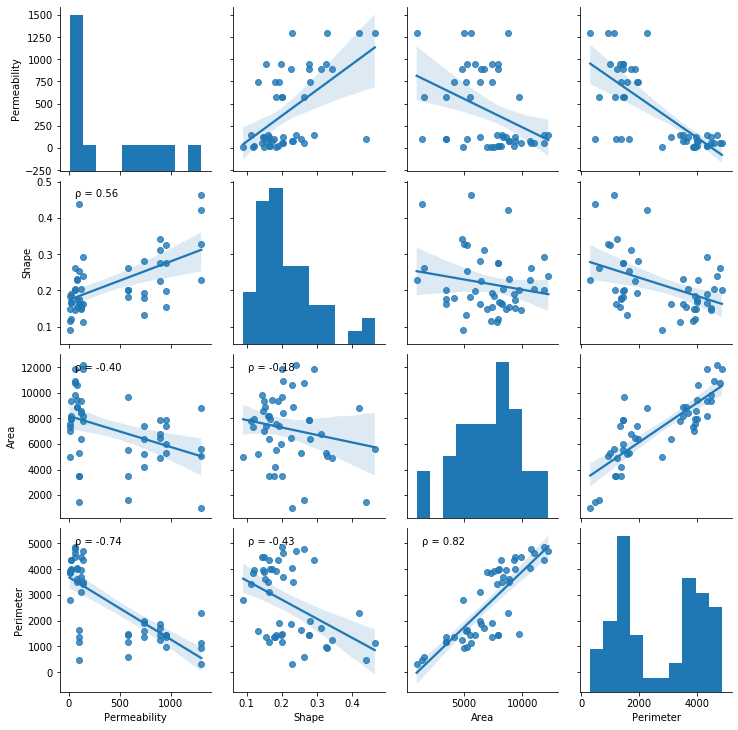

In [11]:
corr_plot(rock)

In [12]:
rock.corr()

,Permeability,Shape,Area,Perimeter
Permeability,1.000000,0.556721,-0.396637,-0.738716
Shape,0.556721,1.000000,-0.182161,-0.433126
Area,-0.396637,-0.182161,1.000000,0.822506
Perimeter,-0.738716,-0.433126,0.822506,1.000000


These plots show the linear correlation between each column. The correlation coefficient values suggest a not so strong linear correlation. 
1. 


I'll try getting the mean for each core sample to see if there'll be a difference. So 12 rows will be created.

In [13]:
per_core = rock.groupby(rock['Permeability'], as_index=False).mean()
per_core

,Permeability,Shape,Area,Perimeter
0,6.3,0.134832,6725.50,3621.12000
1,17.1,0.160810,8366.00,4162.29750
2,58.6,0.202981,10862.50,4684.97750
3,82.4,0.196567,9452.50,3795.75500
4,100.0,0.258275,3432.00,1171.86050
5,119.0,0.166283,8201.50,3811.74500
6,142.0,0.201706,10039.75,3999.49250
7,580.0,0.211574,5089.50,1178.34450
8,740.0,0.196307,5803.75,1714.60000
9,890.0,0.288537,6518.25,1570.01750


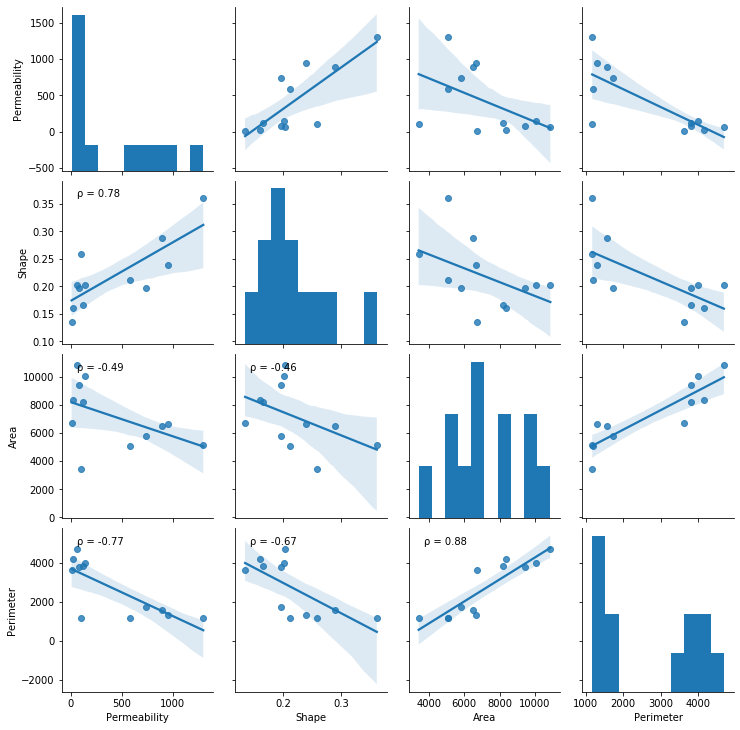

In [14]:
corr_plot(per_core)

It's interesting how the correlation coefficients became closer to 1 for positively correlated values (positive slope), and -1 for negatively correlated values (negative slope), especially for those correlated to pore shape factor. This is good since -1 and 1 values of correlation coefficient shows the strongest/exact linear correlation between two variables.


This can show that permeability values of the core that not solely rely on the property of the pores alone, but also the interconnection of those pores.

Let's see the changes in correlation coefficient.

In [15]:
abs(per_core.corr() - rock.corr())

,Permeability,Shape,Area,Perimeter
Permeability,0.000000,0.223120,0.096035,0.030171
Shape,0.223120,0.000000,0.276239,0.241242
Area,0.096035,0.276239,0.000000,0.061937
Perimeter,0.030171,0.241242,0.061937,0.000000


Using linear regression to model permeability don't 